# In-silico derivatization

The notebook reads a list of SMILES (text file, one molecule per line), and performs in-silico MeOX + TMS derivatization (as described e.g. in https://doi.org/10.1021/acs.analchem.7b01010):

* Metoxylation: ketone R(<font color='#d62828'>C</font>=O)R' and aldehyde (-H<font color='#d62828'>C</font>=O) karboxyl groups are substituted with -<font color='#d62828'>C</font>=NOCH<sub>3</sub>
* Trimethylsilylation: the acidic hydrogen in -OH, -SH, -COOH, -NH<sub>2</sub>, -NHR, =NH, the hydrogen is substituted with -Si(CH<sub>3</sub>)<sub>3</sub>

The probability of all the substitutions can be adjusted, they needn't happen always. Multiple substitution attempts are run on each input molecule, and all distinct results are returned.

Known limitation is metoxylation on cycles which should be broken. This is not implemented yet.

The final outputs are two files:

* `derivs_struct.tsv` with columns (all SMILES):
  * original
  * with derivatization groups stripped
  * column #2 derivatized (multiple times) according to the above rules
* `derivs_flat.txt` – the above with all the smiles flattened, one per line



### Import what we need and setup the environment

In [26]:
from rdkit import Chem
from rdkit.Chem.Draw.IPythonConsole import ShowMols
import random

random.seed(42)

import multiprocessing
from concurrent.futures import ProcessPoolExecutor
cpus = multiprocessing.cpu_count()
print('# cpus (including HT, typically): ', cpus)

# don't run on HT cores, it just makes congestion
cpus //= 2

# cpus (including HT, typically):  24


In [27]:
# import our payload
try:
    import py3Dmol
except ImportError as e:
    !pip install py3dmol

from gc_meox_tms import is_derivatized, remove_derivatization_groups, add_derivatization_groups, process_one_mol
from plotting import draw3d

### Simple checks on manual inputs

In [28]:
for s in ['CCC(=NOC)C', 'CCC=NOC', 'C=NOC', 'C[Si](C)(C)C']:
    print(s, is_derivatized(smiles=s))

CCC(=NOC)C True
CCC=NOC True
C=NOC False
C[Si](C)(C)C False


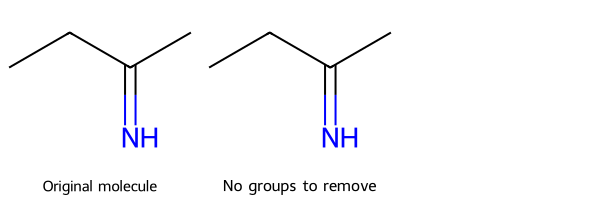

In [29]:
smiles = 'CCC(=N)C'
ShowMols(
    [
        mol := Chem.MolFromSmiles(smiles),
        remove_derivatization_groups(mol=mol)
    ],
    legends=['Original molecule', 'No groups to remove'])

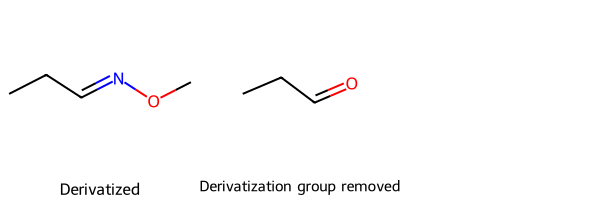

In [30]:
smiles = 'CCC=NOC'
ShowMols(
    [
        mol := Chem.MolFromSmiles(smiles),
        remove_derivatization_groups(mol=mol)
    ],
    legends=['Derivatized', 'Derivatization group removed'])

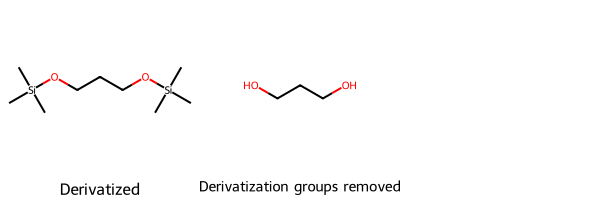

In [31]:
smiles = 'C[Si](C)(C)OCCCO[Si](C)(C)C'
ShowMols(
    [
        mol := Chem.MolFromSmiles(smiles),
        remove_derivatization_groups(mol=mol)
    ],
    legends=['Derivatized', 'Derivatization groups removed'])

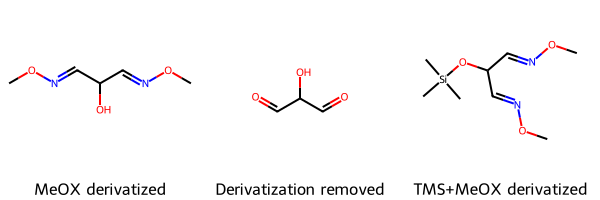

In [32]:
smiles = 'CON=CC(O)C=NOC'
ShowMols(
    [
        der := Chem.MolFromSmiles(smiles),
        orig := remove_derivatization_groups(mol=der),
        add_derivatization_groups(mol=orig)
    ],
    legends=['MeOX derivatized','Derivatization removed','TMS+MeOX derivatized'])

### Read the input file

The file is parsed line by line, errors are reported and ignored otherwise. 

The result is `mol[]`, a list of pairs (_original SMILES_, _RDKit molecule_)

In [33]:
#smi_file='NIST_Si_100.txt'
#smi_file='NIST_Si_all.txt'
#smi_file='NIST_SMILES.txt'
smi_file='NIST_195_200.txt'
with open(smi_file) as f:
    mols = list(filter(lambda p: p[1], [ (smi.rstrip(), Chem.MolFromSmiles(smi)) for smi in f ]))

### Essential statistics

Count occurrences of (one-),di-,tri-methylsilane, TMS attached to -O, -N, -S, and methoximine. 

In [34]:
SiMe1=Chem.MolFromSmarts('[Si][CH3]')
SiMe2=Chem.MolFromSmarts('[Si]([CH3])[CH3]')
SiMe3=Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]')
ONSSi=Chem.MolFromSmarts('[O,N,S][Si]([CH3])([CH3])[CH3]')

print('# total',len(mols))
with_sime1 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe1),mols))
print("# with SiMe:", len(with_sime1))
with_sime2 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe2),mols))
print("# with SiMe2:", len(with_sime2))
with_sime3 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe3),mols))
print("# with SiMe3:", len(with_sime3))
with_onssi = list(filter(lambda m: m[1].HasSubstructMatch(ONSSi),mols))
print("# with ONSSi:", len(with_onssi))

MeOX=Chem.MolFromSmarts('C=NO[CH3]')
with_meox = list(filter(lambda m: m[1].HasSubstructMatch(MeOX),mols))
print("# with MeOX:", len(with_meox))




# total 4
# with SiMe: 1
# with SiMe2: 1
# with SiMe3: 1
# with ONSSi: 1
# with MeOX: 3


### Inspect whatever from the sorted categories

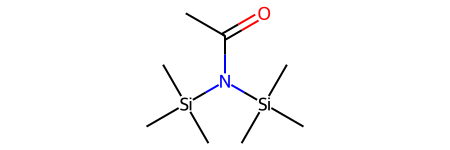

In [35]:
with_sime2[0][1]

In [36]:
draw3d(with_sime2[0][1])

[14:15:16] Molecule does not have explicit Hs. Consider calling AddHs()
[14:15:16] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
draw3d(with_onssi[0][1])

[14:15:16] Molecule does not have explicit Hs. Consider calling AddHs()
[14:15:16] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

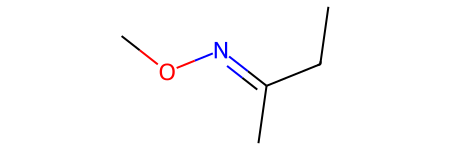

In [38]:
with_meox[0][1]

In [39]:
with open('NIST_ONSSiMe3.txt','w') as f:
    for m in with_onssi:
        f.write(m[0]+'\n')
        
with open('NIST_SiMe3.txt','w') as f:
    for m in with_sime3:
        f.write(m[0]+'\n')
        
with open('NIST_MeOX.txt','w') as f:
    for m in with_meox:
        f.write(m[0]+'\n')

### Run the in-silico derivatization

Iterate over the `mol[]` list (read from file above), remove derivatization groups from each entry, and try derivatization several times to leverage from the probabilistic behaviour). Assemble the results.

This can be time consuming, expect about 5,000 entries per minute per core. Memory consumption can also grow to several GB.

In [40]:
def process_one_mol(mol):
    return (
        mol[0],
        Chem.MolToSmiles(remove_derivatization_groups(mol[1])),
        { Chem.MolToSmiles(add_derivatization_groups(mol[1])) for _ in range(42) }
        )

In [41]:
%%time       
with ProcessPoolExecutor(max_workers=cpus) as executor:
    out = executor.map(process_one_mol, mols)
    
out = list(out)

CPU times: user 18 ms, sys: 14.5 ms, total: 32.5 ms
Wall time: 50.1 ms


### Write the main outputs

In [42]:
with open('derivs_struct.tsv','w') as tsv:
    tsv.write("orig\tderiv. removed\tderiv. added ...\n")
    for orig,removed,added in out:
        tsv.write("\t".join([orig,removed,*added]) + "\n")

In [43]:
with open('derivs_flat.txt','w') as flat:
    for orig,removed,added in out:
        for one in { orig, removed, *added }:
            flat.write(one + "\n")